## Imports

In [8]:
import gc
import logging
import queue
import random
import subprocess
import time
from datetime import datetime
from importlib import reload
from multiprocessing import Process, Manager

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.nn import Module
from torchvision import models, transforms

reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO, datefmt='%I:%M:%S')

## Async Processes

In [9]:
class GPUMonitor(Process):
    def __init__(self, delay):
        super(GPUMonitor, self).__init__()
        self.delay = delay
        self.power_readings = Manager().list()
        self.running = True
        self.command = 'nvidia-smi --query-gpu=power.draw --format=csv,noheader,nounits'.split(' ')
        self.start()

    def run(self):
        while self.running:
            try:
                self.power_readings.append(float(subprocess.check_output(self.command).strip()))
            except:
                logging.error('Something went wrong while retrieving GPU readings...')
            time.sleep(self.delay)

    def reset_energy(self):
        self.power_readings[:] = []

    def get_power_average(self):
        return np.mean(self.power_readings)

    def plot(self):
        plt.plot(self.power_readings)
        plt.show()


class RequestQueue(Process):
    def __init__(self, id, frequency, nr_of_requests):
        super(Process, self).__init__()
        self.id = id
        self.frequency = frequency
        self.nr_of_requests = nr_of_requests
        self.queue = Manager().Queue(nr_of_requests)
        self.total_time_in_queue = Manager().Value(float, 0.0)
        self.batch_start_times = Manager().list()
        self.start()

    def run(self):
        logging.info("Started simulation with id: {}".format(self.id))
        while self.nr_of_requests > 0:
            self.queue.put((random.choice(['img/dog.jpg', 'img/bald_eagle.jpg', 'img/strawberries.jpg']), time.perf_counter()))
            self.nr_of_requests -= 1
            time.sleep(1 / self.frequency * random.uniform(0.8, 1.2))

    def get_request(self, block=True, timeout=None):
        img, t_0 = self.queue.get(block, timeout)
        self.batch_start_times.append(t_0)
        return img

    def update_wait_times(self):
        curr_time = time.perf_counter()
        for img_t0 in self.batch_start_times:
            self.total_time_in_queue.value += curr_time - img_t0
        self.batch_start_times[:] = []



## Initialisation

In [10]:

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
with open('image_net_classes.txt') as file:
    classes = [line.strip().split(', ')[1] for line in file.readlines()]

## Inference

In [11]:
def infer(model: Module, images, use_gpu=True, verbose=False):
    model.eval()
    with torch.no_grad():
        if use_gpu:
            model.cuda()
        images_t = [transform(im) for im in images]
        batch = torch.cat([tensor for tensor in [torch.unsqueeze(im_t, 0) for im_t in images_t]])
        if use_gpu:
            out = model(batch.cuda())
        else:
            out = model(batch)
    if verbose:
        for prediction in out:
            prediction = prediction.cpu()
            _, indices = torch.sort(prediction, descending=True)
            percentages = [(torch.nn.functional.softmax(prediction, dim=0)[class_index] * 100).item() for class_index in
                           indices[:5]]

            logging.info(f'Rank\tInferred class\tProbability(%)')
            for idx, class_index in enumerate(indices[:5]):
                logging.info(f'#{idx}\t\t{classes[class_index]}\t{percentages[idx]}')
            logging.info('-----------------------------------------')


def run_experiment(model_, input_images_):
    t_0 = time.perf_counter()
    infer(model_, input_images_, use_gpu=True)
    return time.perf_counter() - t_0

## Write Results

In [12]:
def write_results(file_name, batch_size):
    file = open(f'results/{file_name}', 'a')
    logging.info(f'Batch Size\tAverage Power(W)\t\tTime(s)\t\t\t\tEnergy(J)\t\t\tAverage Wait Time(s)\tAverage Peak Power (W)')
    logging.info(f'{batch_size}\t\t\t{average}\t\t{duration}\t{average * duration}\t{wait_time}\t\t{peak_average}\n\n')
    file.write(f'{batch_size},{average},{duration},{average * duration},{wait_time},{peak_average}\n')
    file.close()
    logging.info(f'Results logged to: results/{file_name}')

## Configuration

In [13]:
batch_sizes = [16, 32, 64, 128,-1]
frequency = 32
nr_of_requests = 128
model = models.convnext_base(pretrained=True)

## Simulation

03:12:38 INFO: Started simulation with id: inference_simulation_f32_16
03:12:43 INFO: Batch Size	Average Power(W)		Time(s)				Energy(J)			Average Wait Time(s)	Average Peak Power (W)
03:12:43 INFO: 16			106.25679012345678		4.198531207999622	446.1224493951993	0.4792433638361331		174.7903125


03:12:43 INFO: Results logged to: results/ConvNeXt_f32


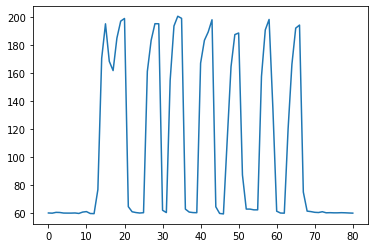

03:12:44 INFO: Started simulation with id: inference_simulation_f32_32
03:12:49 INFO: Batch Size	Average Power(W)		Time(s)				Energy(J)			Average Wait Time(s)	Average Peak Power (W)
03:12:49 INFO: 32			101.10280487804879		4.362793037998927	441.09061324411516	0.9244790299927104		168.4022580645161


03:12:49 INFO: Results logged to: results/ConvNeXt_f32


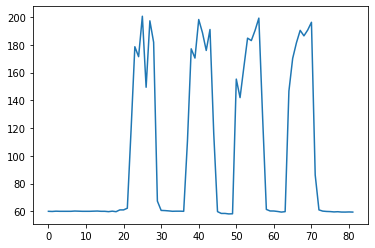

03:12:50 INFO: Started simulation with id: inference_simulation_f32_64
03:12:56 INFO: Batch Size	Average Power(W)		Time(s)				Energy(J)			Average Wait Time(s)	Average Peak Power (W)
03:12:56 INFO: 64			98.47175824175825		5.004734998999993	492.82505488559354	2.00101869642144		180.5906896551724


03:12:56 INFO: Results logged to: results/ConvNeXt_f32


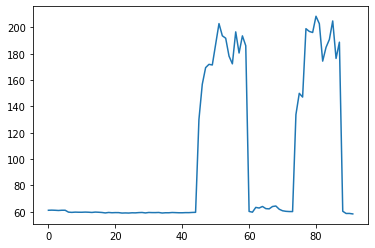

03:12:56 INFO: Started simulation with id: inference_simulation_f32_128
03:13:03 INFO: Batch Size	Average Power(W)		Time(s)				Energy(J)			Average Wait Time(s)	Average Peak Power (W)
03:13:03 INFO: 128			71.28222222222223		5.94924337699922	424.07528845334224	3.9704220604219103		163.58277777777778


03:13:03 INFO: Results logged to: results/ConvNeXt_f32


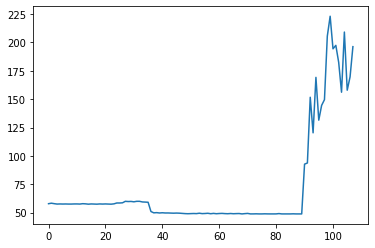

03:13:04 INFO: Started simulation with id: inference_simulation_f32_-1
03:13:10 INFO: Batch Size	Average Power(W)		Time(s)				Energy(J)			Average Wait Time(s)	Average Peak Power (W)
03:13:10 INFO: -1			94.71052631578948		4.194939920000252	397.30496768633964	0.16509796017982126		134.576875


03:13:10 INFO: Results logged to: results/ConvNeXt_f32


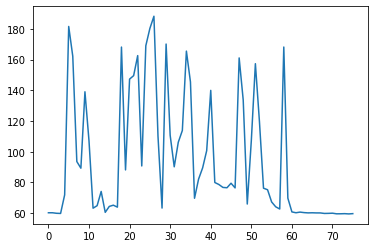

In [14]:
file_name = f'{model.__class__.__name__}_f{frequency}'
file = open(f'results/{file_name}', 'a')
file.write(f'Batch Size,Average Power(W),Time(s),Energy(J),Average Wait Time(s),Average Peak Power (W)\n')
file.close()
for batch_size in batch_sizes:
    torch.cuda.empty_cache()
    gc.collect()
    epsilon = 2 / frequency + 1
    gpu_monitor = GPUMonitor(0.01)
    img_count = 0

    rq = RequestQueue(f'inference_simulation_f{frequency}_{batch_size}', frequency, nr_of_requests)
    t_0 = time.perf_counter()
    while True:
        try:
            batch = [Image.open(rq.get_request(block=True, timeout=epsilon)) for _ in
                     range(max(min(rq.queue.qsize(), 256), 1) if batch_size <= 0 else batch_size)]
            t = run_experiment(model, batch)
            rq.update_wait_times()
            img_count += len(batch)
            # logging.info(f"{100 * img_count / nr_of_requests}% last batch ({len(batch)}) took {t}s")
        except queue.Empty:
            break

    power = gpu_monitor.power_readings[:]
    average = np.mean(power)
    duration = time.perf_counter() - t_0 - epsilon
    wait_time = rq.total_time_in_queue.value / nr_of_requests
    peak_average = np.mean(list(filter(lambda p: p > min(power) + 25, power)))
    write_results(file_name, batch_size)
    gpu_monitor.plot()
    rq.terminate()
    gpu_monitor.terminate()